# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 2</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp


In [2]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 3. Clasificacion

### a. Construcción del target

La idea de este Trabajo es poder predecir el precio de una propiedad.  
El tipo de precio puede ser alto, medio o bajo, y para evaluar el mismo vamos a generarnos una nueva variable en el dataset, que sea el precio por metro cuadrado

In [5]:

viviendas_caba_train.drop(columns=['Unnamed: 0'],inplace=True)


KeyError: "['Unnamed: 0'] not found in axis"

In [52]:
viviendas_caba_train['pxm2'] = viviendas_caba_train.property_price / viviendas_caba_train.property_surface_total
viviendas_caba_train.head()
deptos_a_borrar = viviendas_caba_train[viviendas_caba_train.pxm2 > 20000]
deptos_a_borrar

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2,pxm2_igual_frec,pxm2_25_50_25,tipo_precio_igual_frec,tipo_precio_25_50_25
5104,2021-01-07,2021-06-05,-34.583718,-58.484141,Villa Urquiza,Casa,4.0,3.0,2.252427,1.0,498000.0,"Hermosa casa de 4 ambientes con garage, patio,...",POINT (-58.4841406 -34.583718),221094.803592,Alto,Alto,Alto,Alto
7335,2021-01-12,2021-06-05,-34.573360,-58.441008,Belgrano,Departamento,3.0,2.0,2.252427,1.0,229000.0,3 Ambientes a estrenar c/ cochera y parrilla e...,POINT (-58.4410081 -34.5733603),101668.092415,Alto,Alto,Alto,Alto
8355,2021-03-19,2021-06-05,-34.633402,-58.445774,Parque Chacabuco,Departamento,3.0,2.0,6.865293,5.0,210000.0,Departamento - Parque Chacabuco,POINT (-58.4457742 -34.6334018),30588.644199,Alto,Alto,Alto,Alto
10283,2021-01-12,2021-03-10,-34.570428,-58.477361,Villa Urquiza,PH,3.0,2.0,2.252427,1.0,215000.0,Hermoso Ph de 3 ambientes con 2 patios,POINT (-58.4773612 -34.5704281),95452.575848,Alto,Alto,Alto,Alto
16144,2021-01-12,2021-01-28,-34.589957,-58.482162,Agronomía,PH,4.0,3.0,2.252427,1.0,220000.0,PH 4 AMBIENTES C/TERRAZA A REFACCIONAR,POINT (-58.4821619693 -34.5899568237),97672.403193,Alto,Alto,Alto,Alto
17577,2021-01-05,2022-07-02,-34.624678,-58.524197,Versalles,Casa,3.0,2.0,2.252427,1.0,290000.0,"Inmueble S/Lote de 8,66 x 35,90 y 33,25",POINT (-58.5241975 -34.6246779),128749.986027,Alto,Alto,Alto,Alto
18566,2021-01-12,2021-06-05,-34.572512,-58.478717,Villa Urquiza,Departamento,5.0,4.0,2.252427,1.0,598000.0,Departamento 5 Ambientes c/Dep. Sevicio Terraz...,POINT (-58.4787168 -34.5725118),265491.350498,Alto,Alto,Alto,Alto
24702,2021-01-12,2021-06-05,-34.572157,-58.494807,Villa Urquiza,Departamento,3.0,2.0,2.252427,1.0,285000.0,Hermoso departamento de 3 ambientes cochera cu...,POINT (-58.4948073 -34.5721573),126530.158682,Alto,Alto,Alto,Alto
28944,2021-01-12,2021-06-05,-34.611753,-58.516570,Villa Devoto,Departamento,1.0,1.0,2.252427,1.0,109900.0,Monoambiente al frente con balcón,POINT (-58.5165698 -34.6117531),48791.805050,Alto,Alto,Alto,Alto
35892,2021-01-12,2021-06-05,-34.572512,-58.478717,Villa Urquiza,Departamento,5.0,4.0,2.252427,1.0,598000.0,Departamento 5 Ambientes c/Dep. Sevicio!!! en ...,POINT (-58.4787168 -34.5725118),265491.350498,Alto,Alto,Alto,Alto


Para evaluar el tipo de precio, procedemos a subclasificar el precio por metro cuadrado segun las cantidades de observaciones.  
Primero lo hacemos con cantidad igual de observaciones y luego dividimos en cuartiles , el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.  
Finalmente selecionaremos cada tipo de propiedad y haremos las mismas divisiones mencionadas.

In [29]:
labels=["Bajo","Medio","Alto"]

viviendas_caba_train["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train["pxm2"],q=3, labels=labels)
viviendas_caba_train["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train["pxm2"],q=[0,0.25,0.75,1], labels=labels)
viviendas_agrupada_tipo_precio_igual_frec = viviendas_caba_train.groupby(["tipo_precio_igual_frec"]).count()
viviendas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_depto = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Departamento"]
viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
deptos_agrupado_tipo_precio_igual_frec = viviendas_caba_train_depto.groupby(["tipo_precio_igual_frec"]).count()
deptos_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_depto.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_ph = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"]
viviendas_caba_train_ph["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=3, labels=labels)
viviendas_caba_train_ph["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=[0,0.25,0.75,1], labels=labels)
ph_agrupado_tipo_precio_igual_frec = viviendas_caba_train_ph.groupby(["tipo_precio_igual_frec"]).count()
ph_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_ph.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_casa = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"]
viviendas_caba_train_casa["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=3, labels=labels)
viviendas_caba_train_casa["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=[0,0.25,0.75,1], labels=labels)
casas_agrupada_tipo_precio_igual_frec = viviendas_caba_train_casa.groupby(["tipo_precio_igual_frec"]).count()
casas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train_casa.groupby(["tipo_precio_25_50_25"]).count()


C:\Users\forte\AppData\Local\Temp\ipykernel_36584\3705598243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
C:\Users\forte\AppData\Local\Temp\ipykernel_36584\3705598243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
C:\Users\forte\AppData\Local\Temp\ipy

Y ahora graficamos segun los intervalos obtenidos

[Text(0.5, 1.0, 'Intervalos de viviendas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

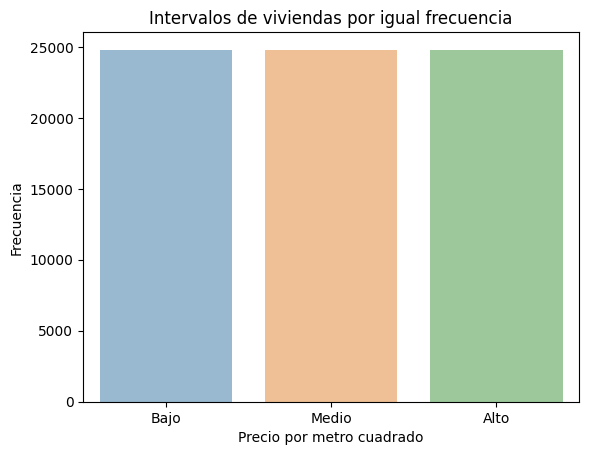

In [30]:
eje_x = viviendas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de viviendas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de viviendas por 25x50x25'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

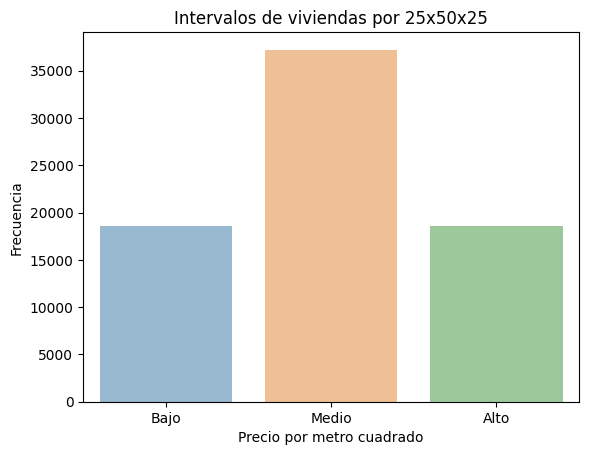

In [31]:
eje_x = viviendas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de viviendas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

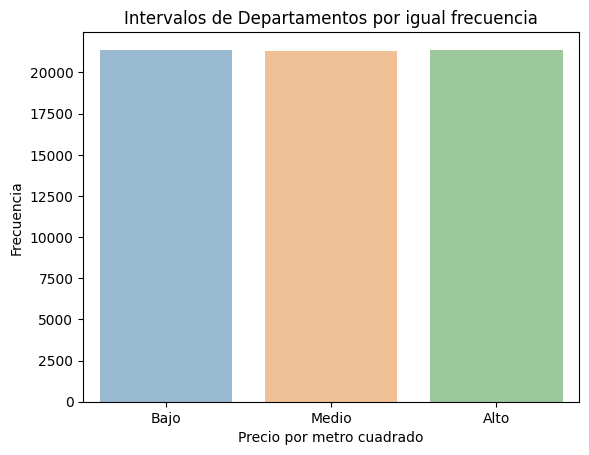

In [34]:
eje_x = deptos_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = deptos_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Departamentos por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por 25x50x25'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

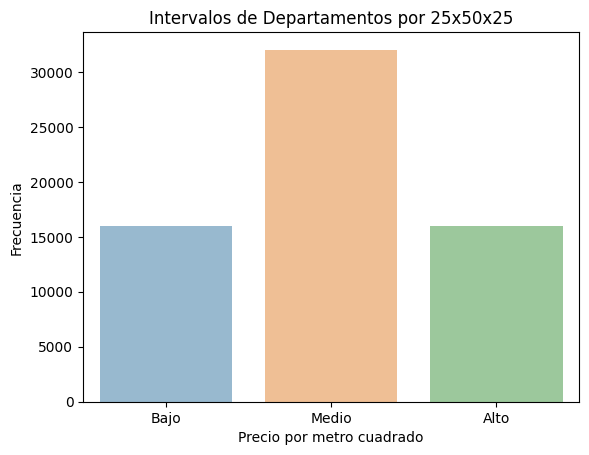

In [35]:
eje_x = deptos_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = deptos_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Departamentos por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de PH por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

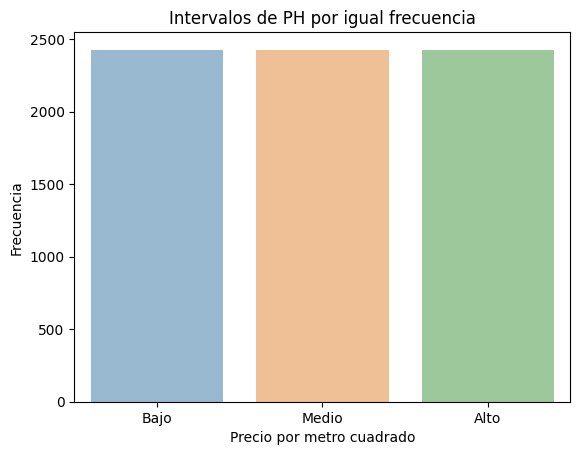

In [36]:
eje_x = ph_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = ph_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de PH por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')


[Text(0.5, 1.0, 'Intervalos de PH por 25x50x25'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

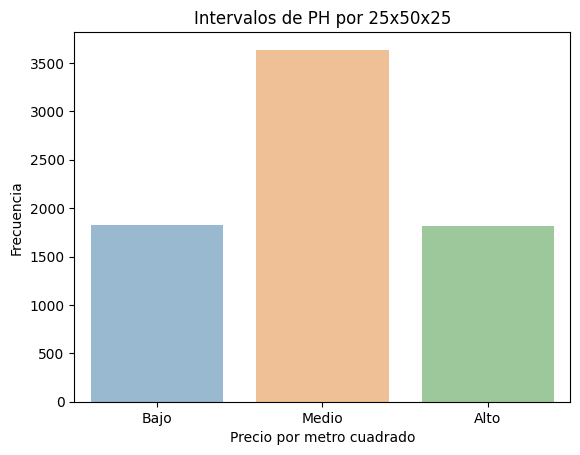

In [37]:
eje_x = ph_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = ph_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de PH por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Casas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

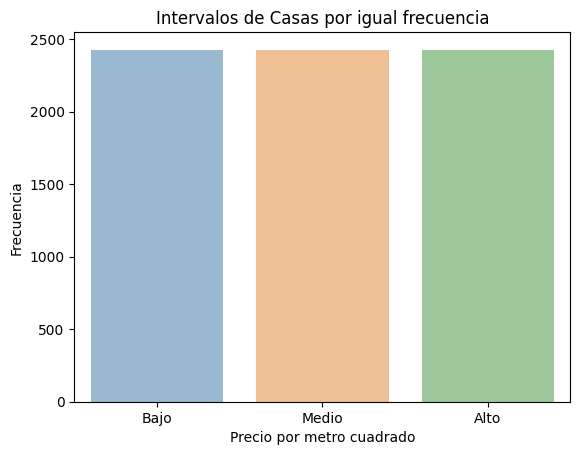

In [38]:
eje_x = casas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = casas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Casas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')



[Text(0.5, 1.0, 'Intervalos de Casas por 25x50x25'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

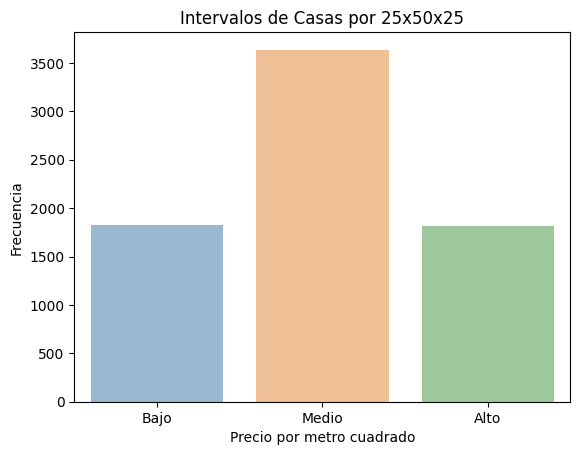

In [39]:
eje_x = casas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = casas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Casas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

Para darnos una idea del target, vamos a mostrar la distribución del precio de las viviendas de todo el dataset


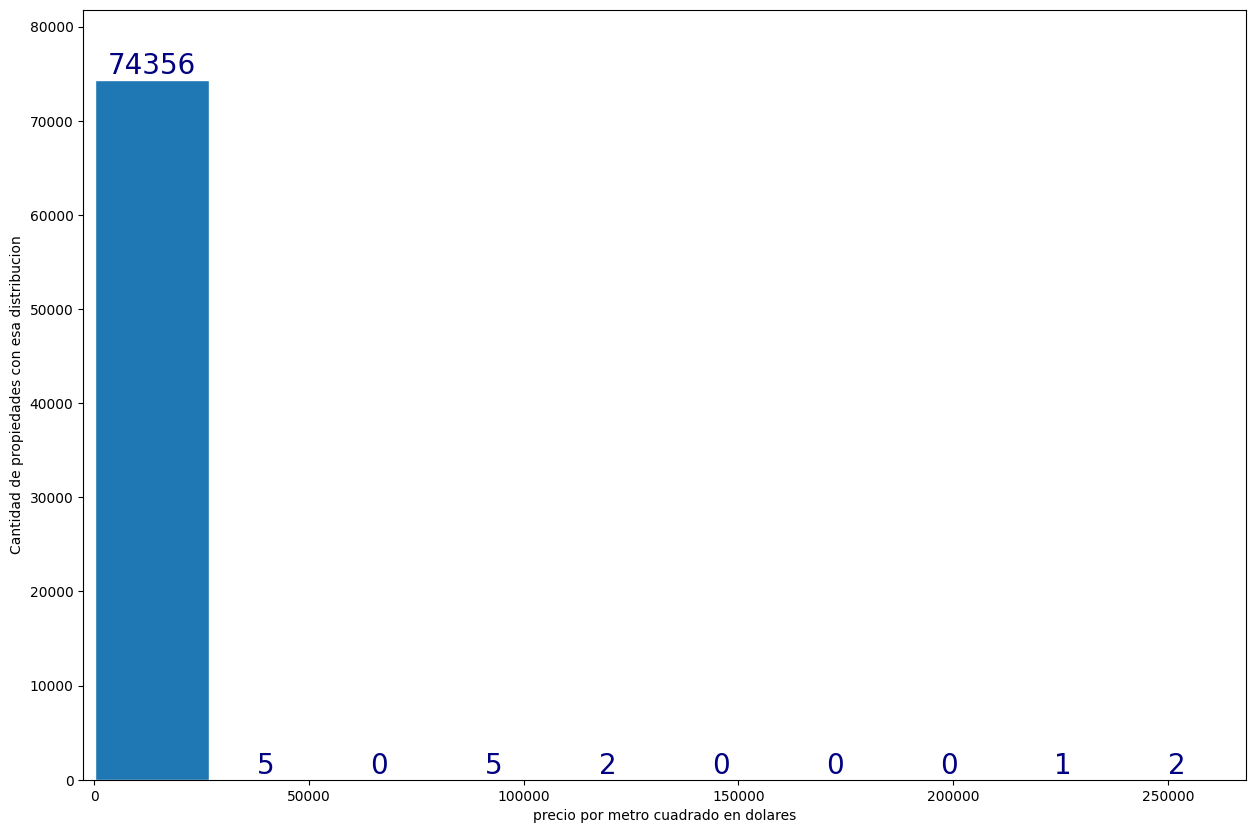

In [45]:
plt.figure(figsize=(15, 10))
values, bins, bars = plt.hist(viviendas_caba_train['pxm2'], edgecolor='white')
plt.xlabel("precio por metro cuadrado en dolares")
plt.ylabel("Cantidad de propiedades con esa distribucion")
plt.title = ('Distribucion precio por metro cuadrado todo dataset')
plt.bar_label(bars, fontsize=20, color='navy')
plt.margins(x=0.01, y=0.1)
plt.show()

Si bien ya era alta, aumento aun mas la tendencia al clustering, no hay dudas de que en el dataset hay agrupamientos de datos.
Debemos verificar cuales son, para eso, seguimos con el analisis determinando la cantidad de clusters optima.

Primero utilizando elbow method

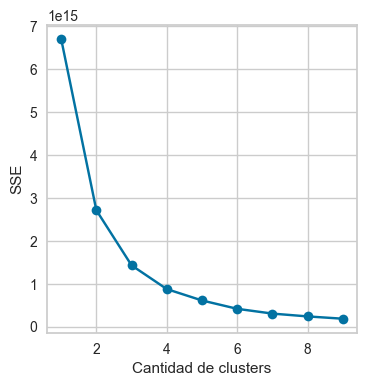

In [137]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(datos_numericos)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(4, 4))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

De aqui vemos que el el "codo" de la funcion esta en 4 clusters. Igualmente podriamos utilizar tambien 5 o 6 clusters para reducir el error aun mas.

Luego, calculamos al silhouette score

In [93]:

#list_k = list(range(2, 6))

#for n_clusters in list_k:
#    clusterer = KMeans(n_clusters=n_clusters)
#    preds = clusterer.fit_predict(datos_numericos)
#
#    score = silhouette_score (datos_numericos , preds)
#    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

#For n_clusters =2 silhouette score is 0.8860751886850246
#For n_clusters =3 silhouette score is 0.7787797603364277
#For n_clusters =4 silhouette score is 0.7049445258428725
#For n_clusters =5 silhouette score is 0.6546668772021881


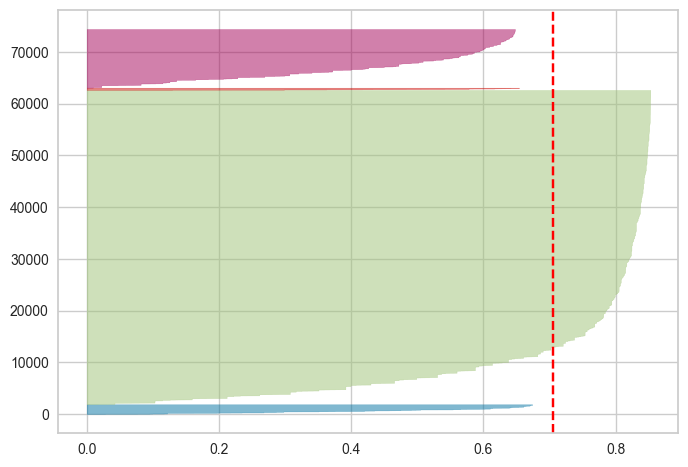

In [94]:
model = KMeans(4, random_state=0)

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(datos_numericos)
plt.show()

De aqui concluimos que para el silhouette method el numero optimo de clusters es 2. 

Comienzo analisis de grupos 

74371


(74371, 7)

In [138]:
print(datos_numericos.columns)

Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price'],
      dtype='object')


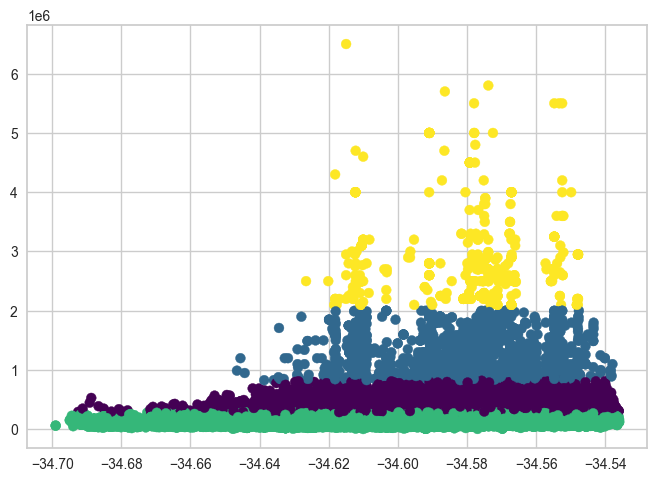

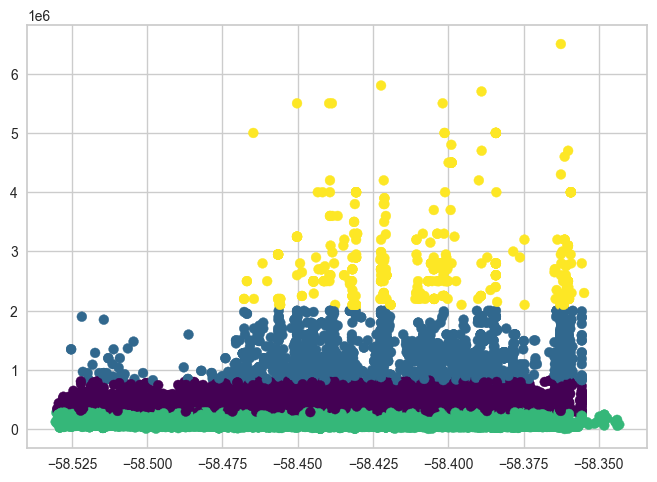

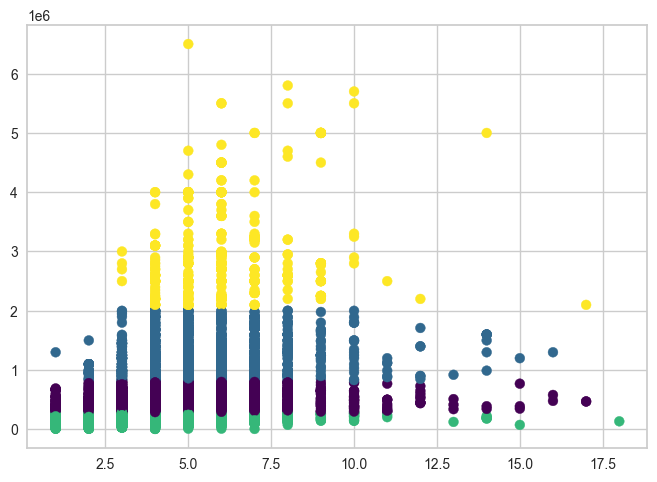

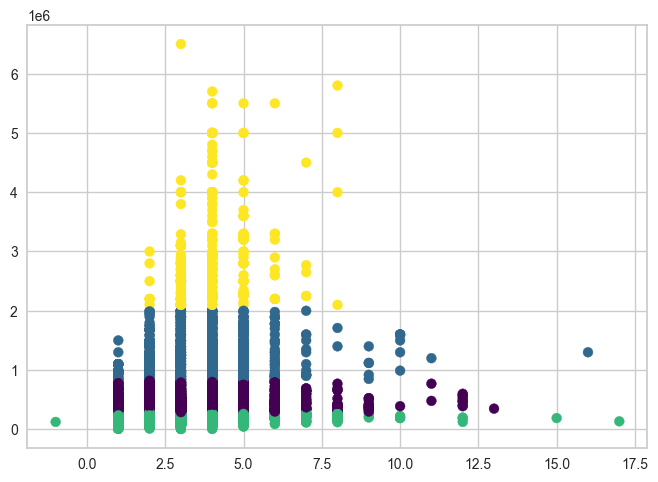

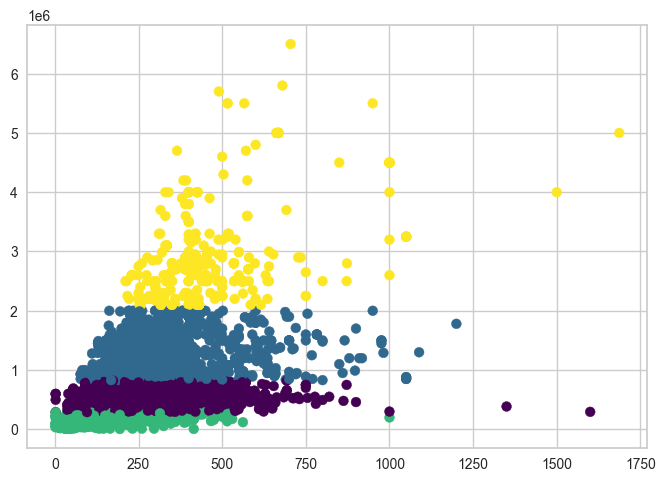

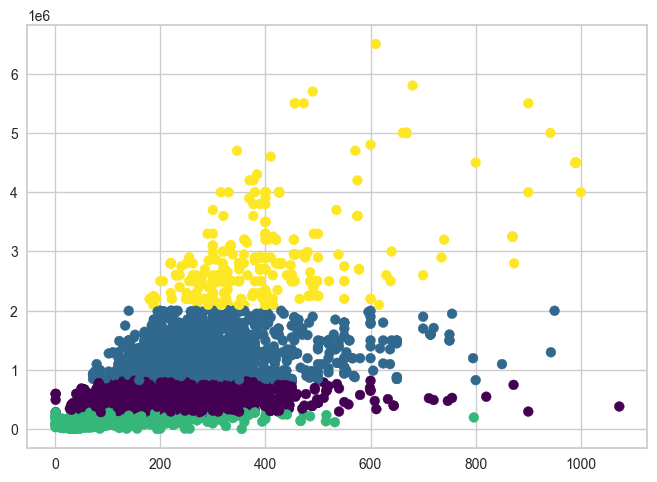

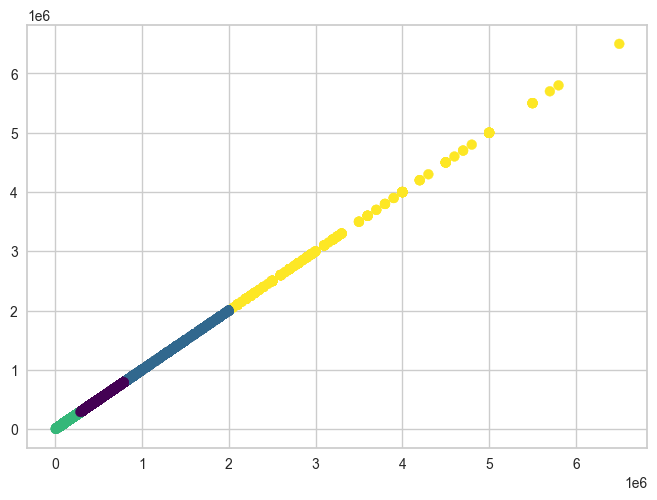

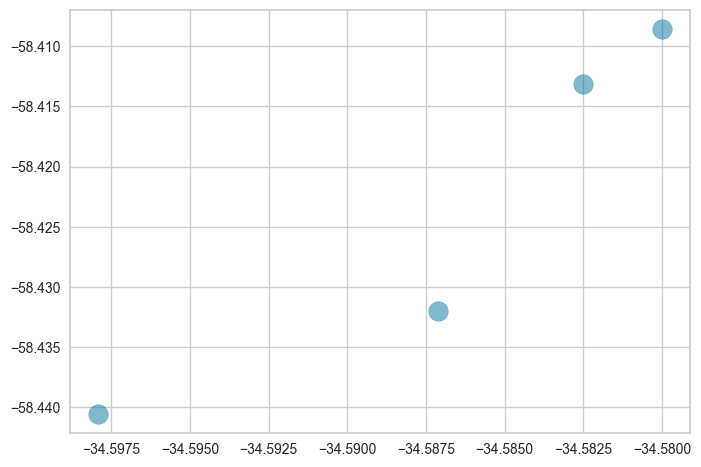

In [143]:
kmeans = KMeans(n_clusters=4)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento
kmeans.fit(datos_numericos) #Entrenamos el algoritmo para que aprenda cómo agrupar
predict = kmeans.predict(datos_numericos)

#for i in predict:
#    print(i)
for i in datos_numericos.columns:
    plt.scatter(datos_numericos.loc[:,i], datos_numericos.loc[:,'property_price'], c=predict, s=50, cmap='viridis' )
    plt.show()

#for i in datos_numericos.columns:
#    for j in datos_numericos.columns:
#        plt.scatter(datos_numericos.loc[:, i], datos_numericos.loc[:, j], c=predict, s=50, cmap='viridis')
#        plt.show()

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5)
plt.show()

In [100]:
kmeans = KMeans(n_clusters=4)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento
kmeans.fit(x_ejemplo1) #Entrenamos el algoritmo para que aprenda cómo agrupar
predict = kmeans.predict(x_ejemplo1)
 print()
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=predict, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,marker='.')
plt.show()

NameError: name 'x_ejemplo1' is not defined